In [1]:
#Construct the matrix A for the discrete Laplacian operator with periodic boundary conditions

import scipy.sparse as sp
import numpy as np
from scipy.integrate import solve_ivp

# Construct A1=\partial_{x}^{2}+\partial_{y}^{2}


def create_laplacian_matrix(n, h):
    """
    Constructs the matrix A for the discrete Laplacian operator with periodic boundary conditions.

    Parameters:
    n (int): The number of grid points along one dimension (assuming an n x n grid).
    h (float): The grid spacing.

    Returns:
    scipy.sparse.csr_matrix: The Laplacian matrix A in sparse format.
    """
    N = n * n  # Total number of points in the grid
    main_diag = -4 * np.ones(N)  # Main diagonal (central point effect)
    main_diag[0] = 2  # Change the top left corner element to 2
    side_diag = np.ones(N - 1)   # Side diagonals for left-right neighbors 
    up_down_diag = np.ones(N - n) # Diagonals for top-bottom neighbors

    # Set up diagonals with periodic boundary conditions
    diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
    offsets = [0, 1, -1, n, -n]

    # Create sparse matrix with diagonals
    A = sp.diags(diagonals, offsets, shape=(N, N), format='csr')

    # The following for loop is dealing with the Periodic boundary conditions
    for i in range(n):
        '''
        For each loop, we are dealing with the boundary condition of the i-th row and i-th column.
        '''
        A[i * n, i * n + n - 1] = 1  # Left edge connected to right edge
        A[i * n + n - 1, i * n] = 1  # Right edge connected to left edge
        A[i, i + (n - 1) * n] = 1    # Top edge connected to bottom edge
        A[i + (n - 1) * n, i] = 1    # Bottom edge connected to top edge

        if i < n - 1:
            A[(i + 1) * n - 1, (i + 1) * n] = 0  # No right neighbor for the last column
            A[(i + 1) * n, (i + 1) * n - 1] = 0  # No left neighbor for the first column

    A = A / h**2  # Multiply by 1/h^2

    return A

n = 64  # Grid size
h = 20/n
A = create_laplacian_matrix(n, h)
A_mat = A.toarray() # Convert to dense array for display (optional)
print("Matrix A is")
print(A_mat)

Matrix A is
[[ 20.48  10.24   0.   ...   0.     0.     0.  ]
 [ 10.24 -40.96  10.24 ...   0.     0.     0.  ]
 [  0.    10.24 -40.96 ...   0.     0.     0.  ]
 ...
 [  0.     0.     0.   ... -40.96  10.24   0.  ]
 [  0.     0.     0.   ...  10.24 -40.96  10.24]
 [  0.     0.     0.   ...   0.    10.24 -40.96]]


/Users/emmazhou/Desktop/UW-Emma/AMATH481-AU24/amath481_env/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [2]:
# Construct A2 = Matrix B =\partial_{x}

def create_y_derivative_matrix(n, h):
    """
    Constructs the matrix B for the discrete x-derivative operator with periodic boundary conditions.

    Parameters:
    n (int): The number of grid points along one dimension (assuming an n x n grid).
    h (float): The grid spacing.

    Returns:
    scipy.sparse.csr_matrix: The x-derivative matrix B in sparse format.
    """
    N = n * n  # Total number of points in the grid
    main_diag = np.zeros(N)  # Main diagonal (central point effect)
    up_down_diag = np.ones(N - n)  # Diagonals for top-bottom neighbors

    # Set up diagonals with periodic boundary conditions
    diagonals = [main_diag, up_down_diag, -up_down_diag]
    offsets = [0, n, -n]

    # Create sparse matrix with diagonals
    B = sp.diags(diagonals, offsets, shape=(N, N), format='csr')

    # The following for loop is dealing with the Periodic boundary conditions
    for i in range(n):
        '''
        For each loop, we are dealing with the boundary condition of the i-th row and i-th column.
        '''
        B[i, i + (n - 1) * n] = -1  # Top edge connected to bottom edge
        B[i + (n - 1) * n, i] = 1  # Bottom edge connected to top edge

    B = B  / (2 * h)  # Multiply by 1/(2h)

    return B

n = 64  # Grid size
h = 20/n  # Assuming a grid over [-10, 10]
# h=0.5 # Just for testing
B = create_y_derivative_matrix(n, h)
B_mat = B.toarray() # Convert to dense array for display (optional)
print("Matrix B is")
print(B_mat)

Matrix B is
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
# Construct A3 = Matrix C =\partial_{y}

def create_x_derivative_matrix(n, h):
    """
    Constructs the matrix C for the discrete y-derivative operator with periodic boundary conditions.

    Parameters:
    n (int): The number of grid points along one dimension (assuming an n x n grid).
    h (float): The grid spacing.

    Returns:
    scipy.sparse.csr_matrix: The y-derivative matrix C in sparse format.
    """
    N = n * n  # Total number of points in the grid
    main_diag = np.zeros(N)  # Main diagonal (central point effect)
    side_diag = np.ones(N - 1)  # Side diagonals for left-right neighbors

    # Set up diagonals with periodic boundary conditions
    diagonals = [main_diag, side_diag, -side_diag]
    offsets = [0, 1, -1]

    # Create sparse matrix with diagonals
    C = sp.diags(diagonals, offsets, shape=(N, N), format='csr')

    # The following for loop is dealing with the Periodic boundary conditions
    for i in range(n):
        '''
        For each loop, we are dealing with the boundary condition of the i-th row and i-th column.
        '''
        C[i * n, i * n + n - 1] = -1  # Left edge connected to right edge
        C[i * n + n - 1, i * n] = 1  # Right edge connected to left edge

        if i < n - 1:
            C[(i + 1) * n - 1, (i + 1) * n] = 0 # No right neighbor for the last column
            C[(i + 1) * n, (i + 1) * n - 1] = 0 # No left neighbor for the first column

    C = C / (2 * h)  # Multiply by 1/(2h)

    return C

n = 64  # Grid size
h = 20/n  # Assuming a grid over [-10, 10]
# h=0.5 # Just for testing
C = create_x_derivative_matrix(n, h)
C_mat = C.toarray() # Convert to dense array for display (optional)
print("Matrix C is:")
print(C_mat)


Matrix C is:
[[ 0.   1.6  0.  ...  0.   0.   0. ]
 [-1.6  0.   1.6 ...  0.   0.   0. ]
 [ 0.  -1.6  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.   1.6  0. ]
 [ 0.   0.   0.  ... -1.6  0.   1.6]
 [ 0.   0.   0.  ...  0.  -1.6  0. ]]


FFT method took 0.69 seconds
[[2.50656748e-46 3.59463241e-45 1.89184423e-44 ... 1.90829318e-42
  4.82312576e-42 1.14798599e-41]
 [1.17762859e-43 6.52986857e-43 2.62284086e-42 ... 1.58841723e-40
  3.56140334e-40 7.46698227e-40]
 [4.55107657e-41 1.92940598e-40 6.43549113e-40 ... 2.49181217e-38
  5.07910904e-38 9.69850405e-38]
 ...
 [1.96785570e-38 1.23404992e-37 5.47738694e-37 ... 4.35424420e-35
  1.02310667e-34 2.22832648e-34]
 [6.19028421e-41 5.33954726e-40 2.94103360e-39 ... 3.68194827e-37
  9.45456547e-37 2.23543799e-36]
 [1.60178709e-43 1.99512062e-42 1.41638252e-41 ... 2.79999590e-39
  7.95709243e-39 2.07535843e-38]]


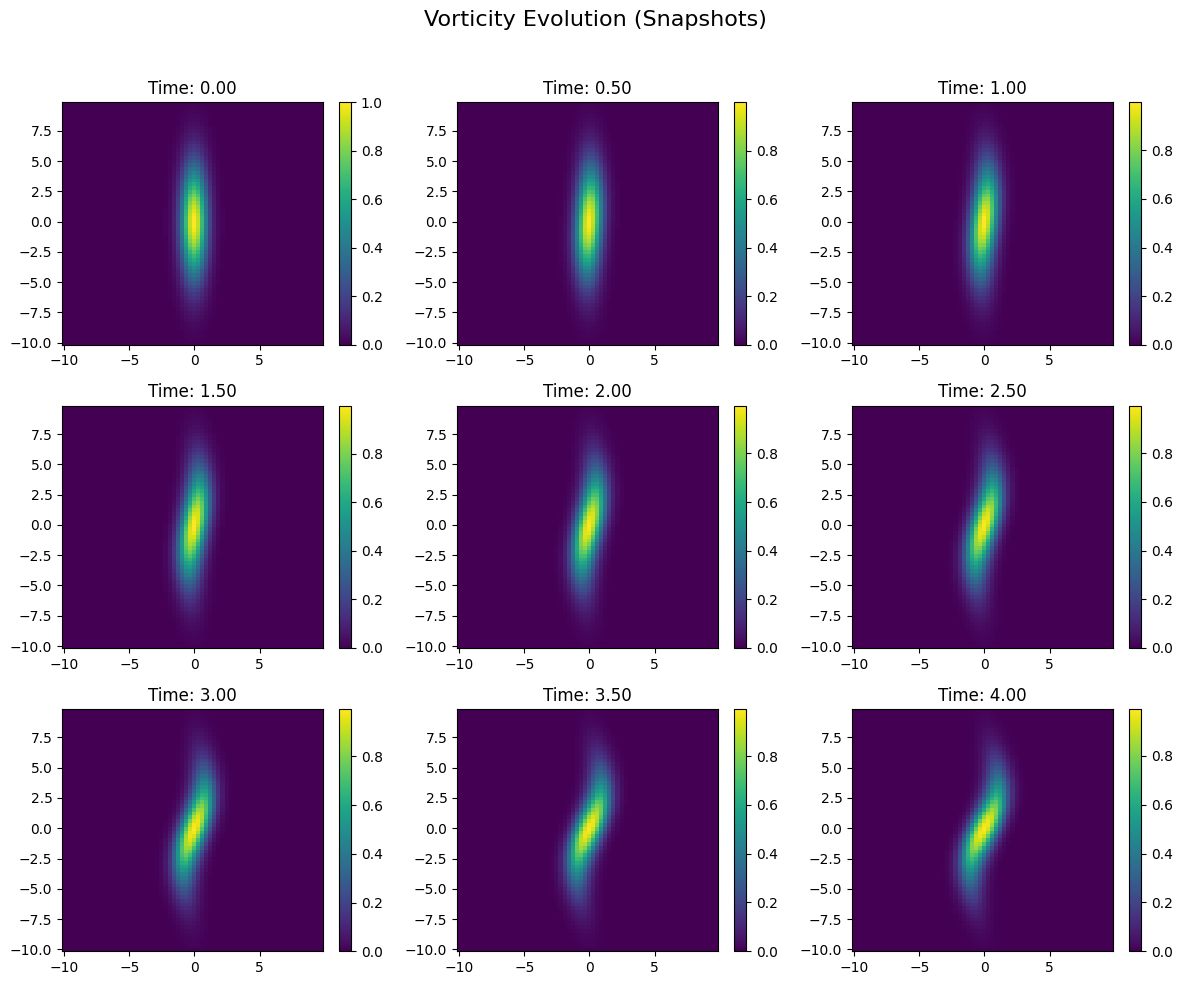

In [ ]:
# part (a)
# Using fast Fourier transform to solve the 2D vorticity equation
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
import time
# import imageio

methods = ["FFT", "A\\b", "LU", "BICGSTAB", "GMRES"]
timings = []

start_time = time.time()
# Define parameters
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
tspan = np.arange(0, 4.5, 0.5)  # Time range

# Define spatial domain and initial conditions
x = np.linspace(-Lx/2, Lx/2, nx + 1)
x2 = x[:nx]
y = np.linspace(-Ly/2, Ly/2, ny + 1)
y2 = y[:ny]
X, Y = np.meshgrid(x2, y2)
omega_init = np.exp(-X**2 - Y**2 / 20)  # Initial vorticity
w2 = omega_init.reshape(N)  # Flatten to 1D

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate([np.arange(0, nx//2), np.arange(-nx//2, 0)])
ky = (2 * np.pi / Ly) * np.concatenate([np.arange(0, ny//2), np.arange(-ny//2, 0)])
kx[0] = 1e-6  # Avoid division by zero
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define the ODE system for vorticity evolution
def spc_rhs(t, w2, nx, ny, N, A_mat, B_mat, C_mat, K, nu):
      # Combine real and imaginary parts
    w = w2.reshape((nx, ny))  # Reshape to 2D
    wt = fft2(w)  # Transform to Fourier space
    psit = -wt / K  # Solve ∇²ψ = ω in Fourier space
    psi = np.real(ifft2(psit)).reshape(N)  # Transform back to physical space
    rhs = nu * np.dot(A_mat, w2) - np.dot(B_mat, psi)*np.dot(C_mat, w2) + np.dot(C_mat, psi)*np.dot(B_mat, w2) # Compute RHS
    return rhs  # Return concatenated real/imag

# Solve the ODE system
wsol = solve_ivp(spc_rhs, [0, 4], w2, args=(nx, ny, N, A_mat, B_mat, C_mat, K, nu), t_eval=tspan, method='RK45')
A1 = wsol.y

timings.append(time.time() - start_time)
print(f"FFT method took {timings[-1]:.2f} seconds")

print(A1)

# Plotting snapshots of vorticity evolution
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
fig.suptitle("Vorticity Evolution (Snapshots)", fontsize=16)

for idx, t_idx in enumerate(range(len(tspan))):
    row, col = divmod(idx, 3)
    ax = axes[row, col]

    # Reshape the vorticity at this time step to 2D
    omega_t = A1[:, t_idx].reshape((nx, ny))
    
    # Plot vorticity
    c = ax.pcolor(X, Y, omega_t, shading='auto', cmap='viridis')
    ax.set_title(f"Time: {tspan[t_idx]:.2f}")
    fig.colorbar(c, ax=ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a GIF for visualization
images = []
for t_idx in range(len(tspan)):
  fig, ax = plt.subplots()
  omega_t = A1[:, t_idx].reshape((nx, ny))
  c = ax.pcolor(X, Y, omega_t, shading='auto', cmap='viridis')
  ax.set_title(f"Time: {tspan[t_idx]:.2f}")
  fig.colorbar(c, ax=ax)
  plt.close(fig)
  
  # Convert plot to image array
  fig.canvas.draw()
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  images.append(image)

# Save images as a GIF
imageio.mimsave('vorticity_evolution.gif', images, fps=2)


In [5]:
#part (b)
#Method 1: A\b

start_time = time.time()
def spc_rhs_ab(t, w2, nx, ny, N, A_mat, B_mat, C_mat, nu):
    w = w2.reshape((nx, ny))  # Reshape vorticity to 2D
    b = w.flatten()  # Flatten vorticity to 1D
    psi = np.linalg.solve(A_mat, b)  # Solve A psi = omega

    # Compute the RHS terms
    rhs = nu * np.dot(A_mat, w2) - np.dot(B_mat, psi) * np.dot(C_mat, w2) + np.dot(C_mat, psi) * np.dot(B_mat, w2)
    return rhs

# Solve using A\b method
wsol_ab = solve_ivp(
    spc_rhs_ab, [0, 4], w2,
    args=(nx, ny, N, A_mat, B_mat, C_mat, nu),
    t_eval=tspan, method='RK45'
)
A2 = wsol_ab.y
timings.append(time.time() - start_time)
print(f"A\\b method took {timings[-1]:.2f} seconds")

print(A2)

A\b method took 15.35 seconds
[[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


In [6]:
# Method 2: LU Decomposition
from scipy.linalg import lu, solve_triangular

start_time = time.time()
# Perform LU decomposition of Laplacian_A
P, L, U = lu(A_mat)

def spc_rhs_lu(t, w2, nx, ny, N, A_mat, B_mat, C_mat, P, L, U, nu):
    w = w2.reshape((nx, ny))  # Reshape vorticity to 2D
    b = w.flatten()  # Flatten vorticity to 1D

    # Solve A psi = b using LU decomposition
    Pb = np.dot(P, b)  # Apply permutation matrix
    y = solve_triangular(L, Pb, lower=True, trans=0)  # Forward substitution
    psi = solve_triangular(U, y, lower=False, trans=0)  # Backward substitution

    # Compute the RHS terms
    rhs = nu * np.dot(A_mat, w2) - np.dot(B_mat, psi) * np.dot(C_mat, w2) + np.dot(C_mat, psi) * np.dot(B_mat, w2)
    return rhs

# Solve using LU decomposition method
wsol_lu = solve_ivp(
    spc_rhs_lu, [0, 4], w2,
    args=(nx, ny, N, A_mat, B_mat, C_mat, P, L, U, nu),
    t_eval=tspan, method='RK45'
)
A3 = wsol_lu.y
timings.append(time.time() - start_time)
print(f"LU method took {timings[-1]:.2f} seconds")
print(A3)


LU method took 1.98 seconds
[[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


In [7]:
from scipy.sparse.linalg import bicgstab

# Method 3: BICGSTAB
start_time = time.time()
def spc_rhs_bicgstab(t, w2, nx, ny, N, A_mat, B_mat, C_mat, nu):
    w = w2.reshape((nx, ny))  # Reshape vorticity to 2D
    b = w.flatten()  # Flatten vorticity to 1D
    psi, _ = bicgstab(A_mat, b)  # Solve A psi = b using BICGSTAB

    # Compute the RHS terms
    rhs = nu * np.dot(A_mat, w2) - np.dot(B_mat, psi) * np.dot(C_mat, w2) + np.dot(C_mat, psi) * np.dot(B_mat, w2)
    return rhs

# Solve using BICGSTAB method
wsol_bicgstab = solve_ivp(
    spc_rhs_bicgstab, [0, 4], w2,
    args=(nx, ny, N, A_mat, B_mat, C_mat, nu),
    t_eval=tspan, method='RK45'
)
A4 = wsol_bicgstab.y
timings.append(time.time() - start_time)
print(f"BICGSTAB method took {timings[-1]:.2f} seconds")
print(A4)

BICGSTAB method took 85.54 seconds
[[ 2.50656748e-46 -3.15845863e-37  4.82395217e-37 ... -5.53269108e-25
  -1.84260249e-25  2.74547230e-24]
 [ 1.17762859e-43 -3.40342242e-30  5.26907497e-30 ... -1.69979211e-18
   6.47541678e-19  1.51307905e-18]
 [ 4.55107657e-41 -6.38142012e-30  9.66706351e-30 ... -2.06452752e-19
  -1.06719882e-19  1.11384157e-18]
 ...
 [ 1.96785570e-38  1.02272394e-28 -1.34398473e-28 ...  4.54131968e-19
  -2.46858226e-19 -8.11252282e-19]
 [ 6.19028421e-41  2.44651396e-29 -3.34443584e-29 ...  3.23467680e-19
  -1.01168370e-19 -8.82206482e-19]
 [ 1.60178709e-43  7.39848617e-30 -1.05001414e-29 ...  3.05594443e-19
  -2.43089770e-19  3.74832154e-20]]


In [8]:
# Method 4: GMRES
from scipy.sparse.linalg import gmres

start_time = time.time()

def spc_rhs_gmres(t, w2, nx, ny, N, A_mat, B_mat, C_mat, nu):
    w = w2.reshape((nx, ny))  # Reshape vorticity to 2D
    b = w.flatten()  # Flatten vorticity to 1D
    psi, _ = gmres(A_mat, b)  # Solve A psi = b using GMRES

    # Compute the RHS terms
    rhs = nu * np.dot(A_mat, w2) - np.dot(B_mat, psi) * np.dot(C_mat, w2) + np.dot(C_mat, psi) * np.dot(B_mat, w2)
    return rhs

# Solve using GMRES method
wsol_gmres = solve_ivp(
    spc_rhs_gmres, [0, 4], w2,
    args=(nx, ny, N, A_mat, B_mat, C_mat, nu),
    t_eval=tspan, method='RK45'
)
A5 = wsol_gmres.y
timings.append(time.time() - start_time)
print(f"GMRES method took {timings[-1]:.2f} seconds")
print(A5)

GMRES method took 748.27 seconds
[[ 2.50656748e-46 -1.78573497e-36  1.02583470e-36 ... -5.74328990e-26
  -6.67580991e-25  3.02014688e-24]
 [ 1.17762859e-43 -2.25993316e-29  1.85528893e-29 ... -1.48124451e-19
  -7.81943913e-19  1.67351283e-18]
 [ 4.55107657e-41 -4.24496061e-29  3.48578079e-29 ... -2.19871214e-20
  -2.91438708e-19  1.23873954e-18]
 ...
 [ 1.96785570e-38  7.20611398e-28 -6.58563606e-28 ...  4.01209213e-20
   1.34318696e-19 -8.93703665e-19]
 [ 6.19028421e-41  1.69064782e-28 -1.49156846e-28 ...  3.00105475e-20
   1.75917699e-19 -9.80154616e-19]
 [ 1.60178709e-43  5.05655534e-29 -4.37882934e-29 ...  2.47405365e-20
   1.15698046e-20  3.11197158e-20]]


In [9]:
# Report timings
for i, method in enumerate(methods):
    print(f"{method}: {timings[i]:.2f} seconds")

FFT: 0.69 seconds
A\b: 15.35 seconds
LU: 1.98 seconds
BICGSTAB: 85.54 seconds
GMRES: 748.27 seconds


Elapsed time for solver (Opposites charged vortices): 1.72 seconds


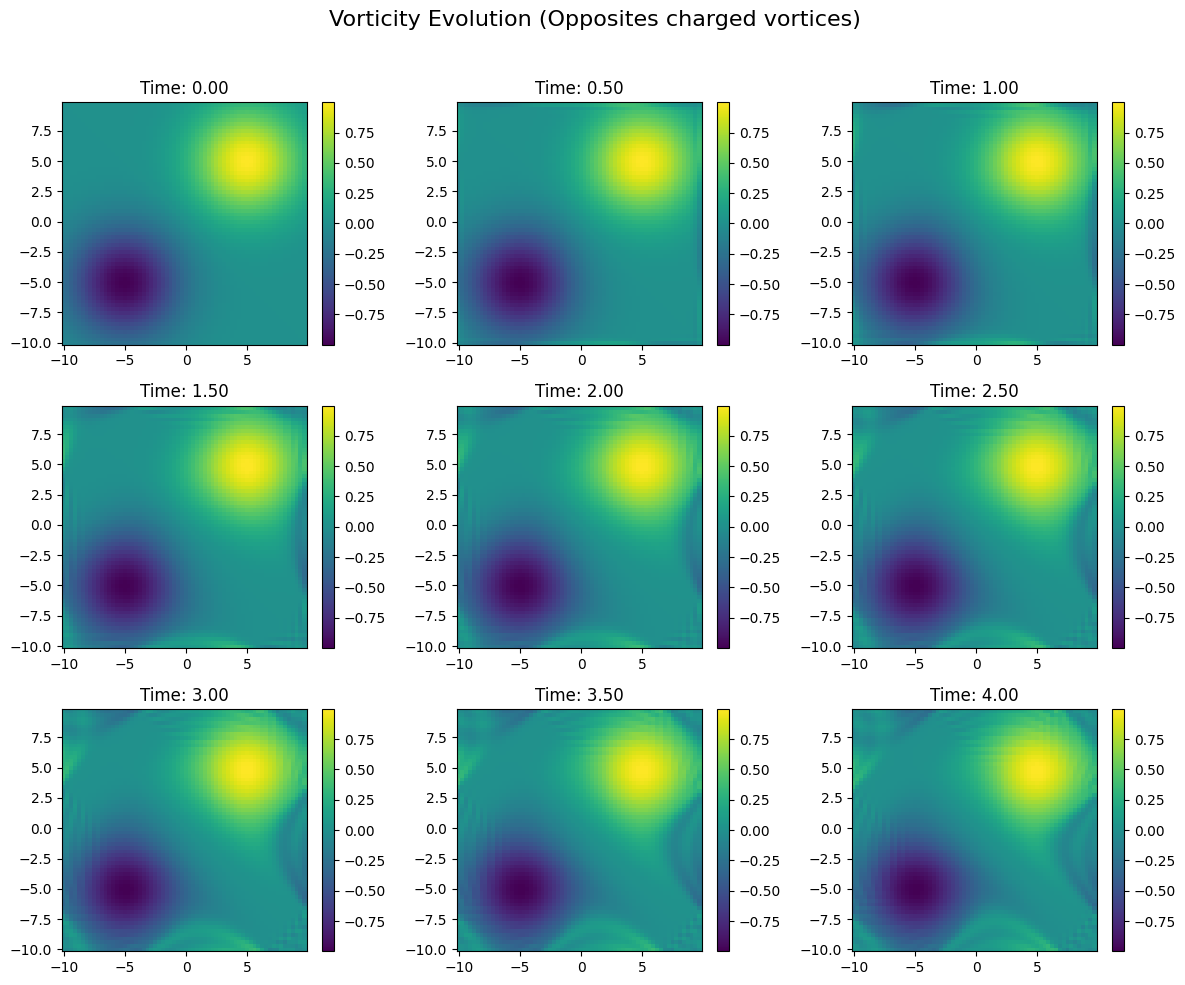

Elapsed time for solver (Same charged vortices): 0.90 seconds


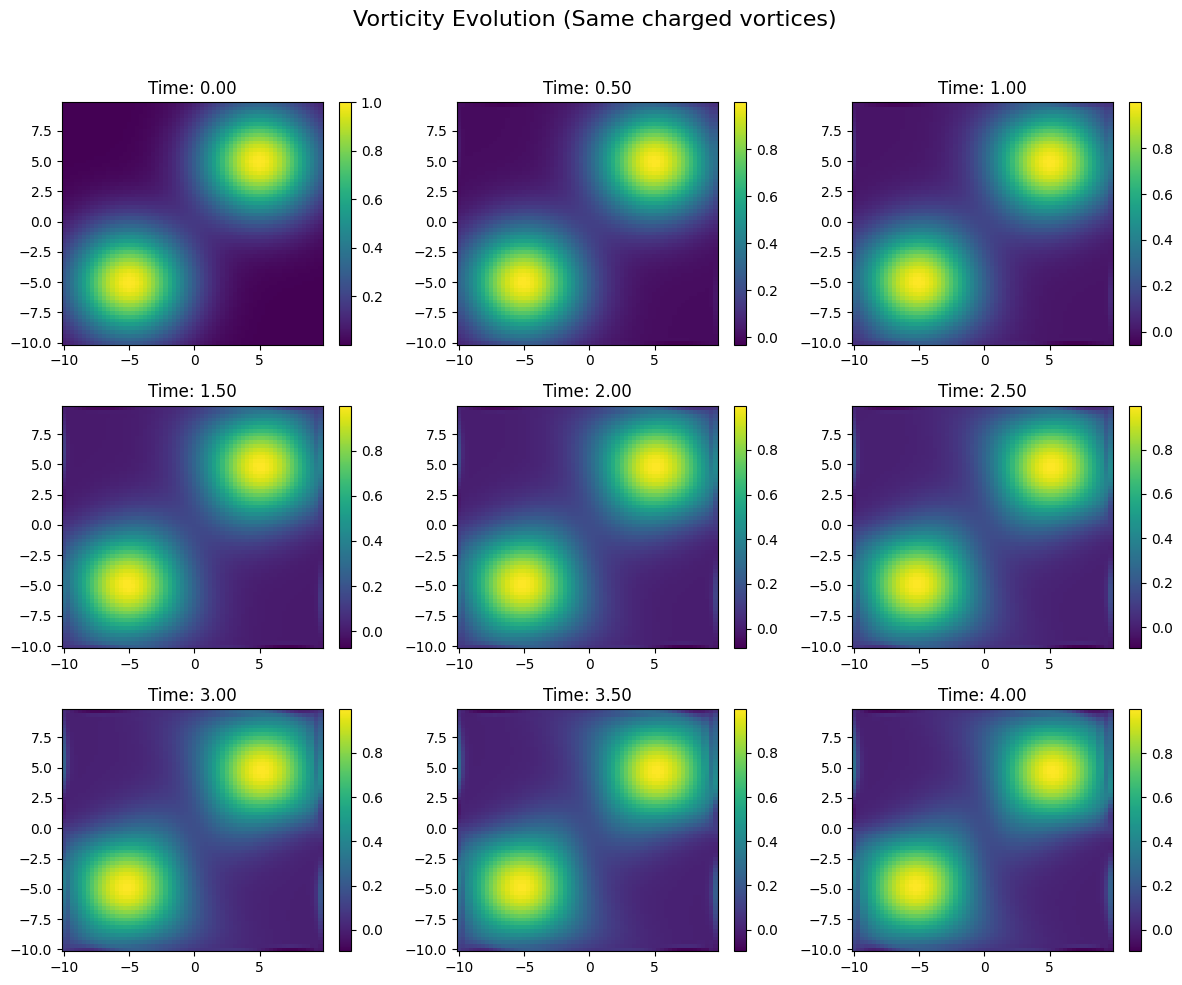

Elapsed time for solver (Colliding vortices): 3.64 seconds


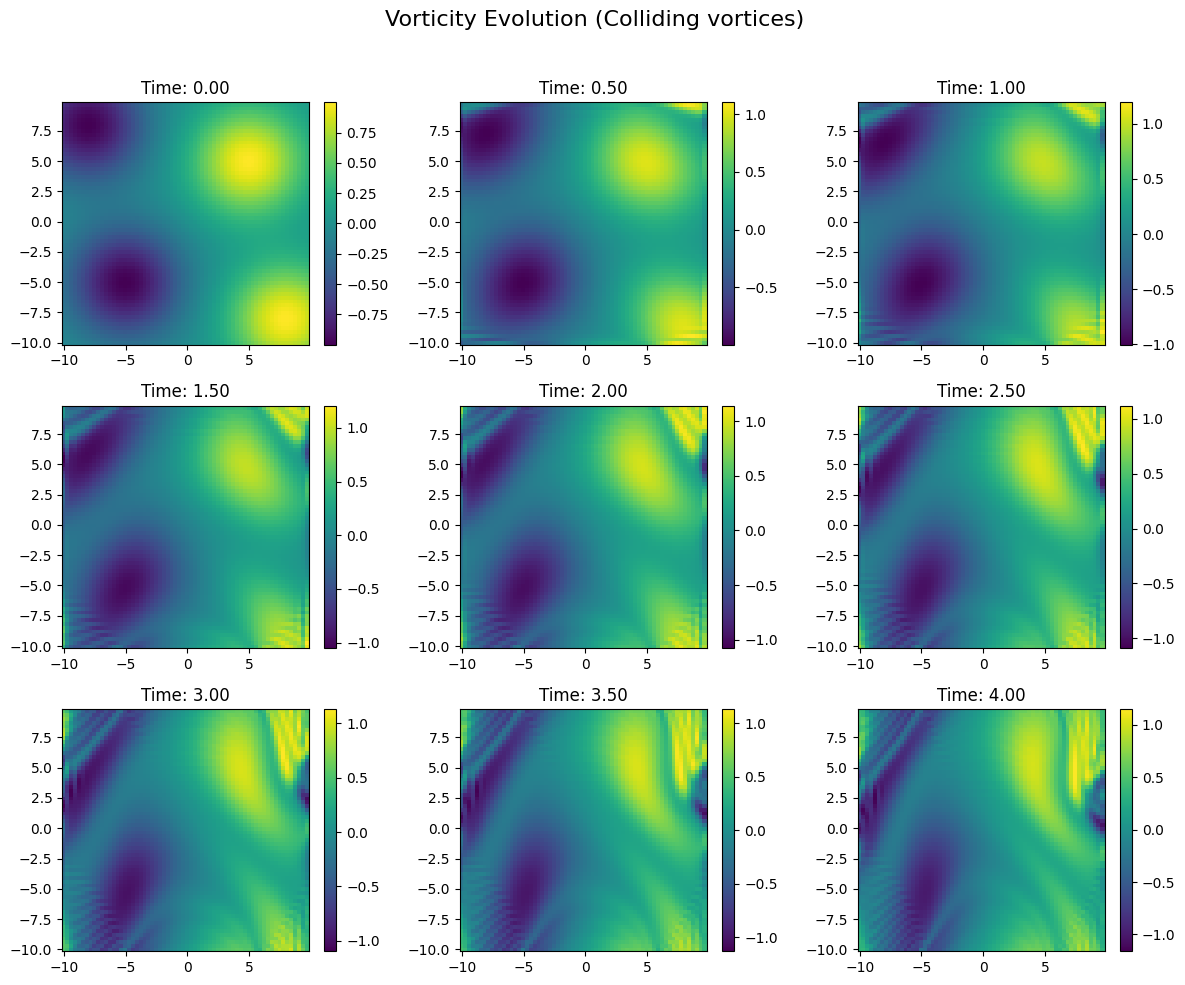

Elapsed time for solver (Random vortices): 1.48 seconds


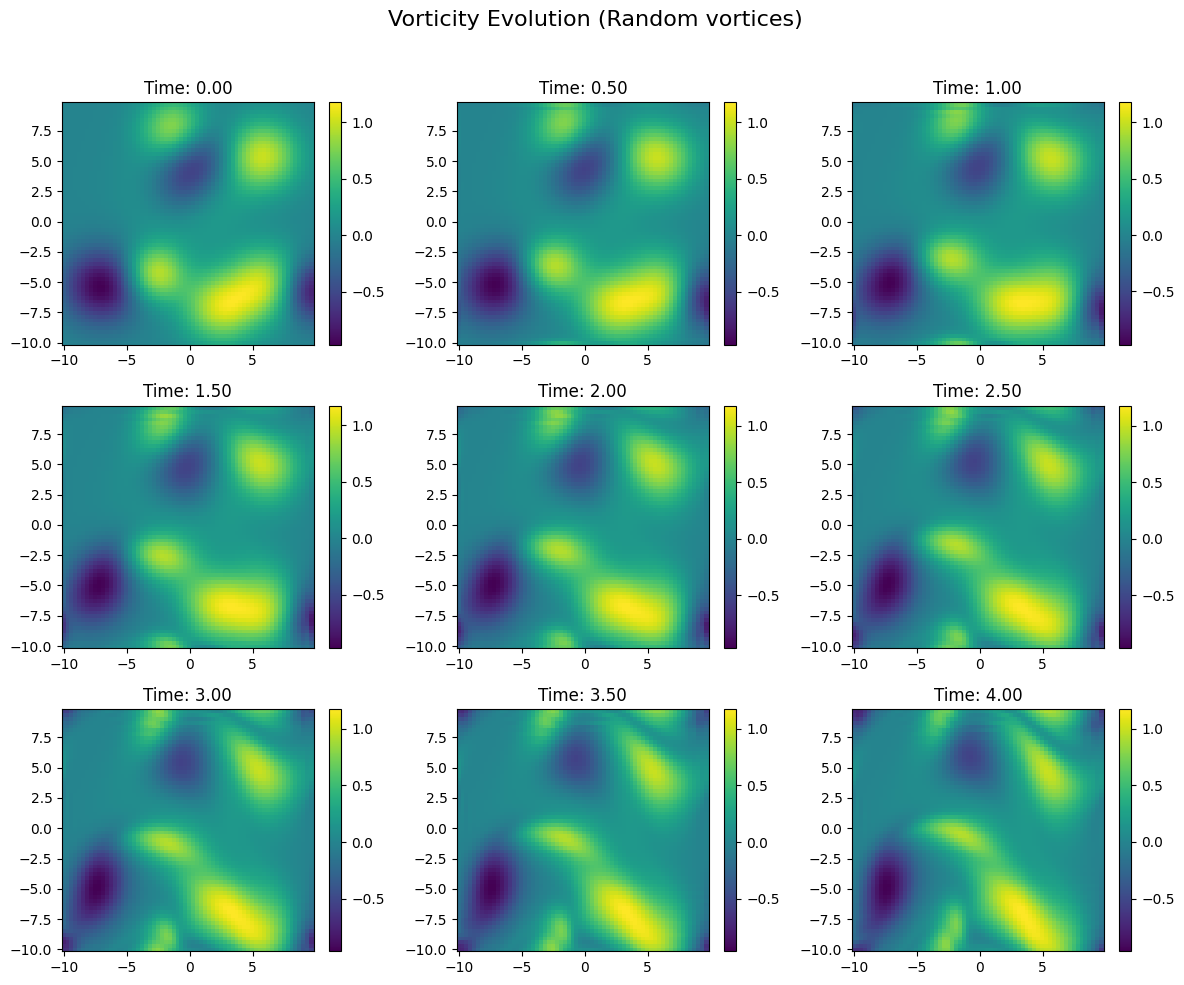

In [16]:
# part (c)
# Set parameters
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
tspan = np.arange(0, 4.5, 0.5)  # Time range

# Define spatial domain
x = np.linspace(-Lx/2, Lx/2, nx + 1)
x2 = x[:nx]
y = np.linspace(-Ly/2, Ly/2, ny + 1)
y2 = y[:ny]
X, Y = np.meshgrid(x2, y2)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate([np.arange(0, nx//2), np.arange(-nx//2, 0)])
ky = (2 * np.pi / Ly) * np.concatenate([np.arange(0, ny//2), np.arange(-ny//2, 0)])
kx[0] = 1e-6  # Avoid division by zero
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define the ODE system for vorticity evolution
def spc_rhs(t, w2, nx, ny, N, A_mat, B_mat, C_mat, K, nu):
    w = w2.reshape((nx, ny))  # Reshape to 2D
    wt = fft2(w)  # Transform to Fourier space
    psit = -wt / K  # Solve ∇²ψ = ω in Fourier space
    psi = np.real(ifft2(psit)).reshape(N)  # Transform back to physical space
    rhs = nu * np.dot(A_mat, w2) - np.dot(B_mat, psi)*np.dot(C_mat, w2) + np.dot(C_mat, psi)*np.dot(B_mat, w2)  # Compute RHS
    return rhs  # Return concatenated real/imag

# Initial condition 1: Two oppositely charged Gaussian vortices
def initial_condition_1(X, Y):
    return np.exp(-((X - 5)**2 + (Y - 5)**2) / 20) - np.exp(-((X + 5)**2 + (Y + 5)**2) / 20)

# Initial condition 2: Two same charged Gaussian vortices
def initial_condition_2(X, Y):
    return np.exp(-((X - 5)**2 + (Y - 5)**2) / 20) + np.exp(-((X + 5)**2 + (Y + 5)**2) / 20)

# Initial condition 3: Two pairs of oppositely charged vortices that will collide
def initial_condition_3(X, Y):
    return np.exp(-((X - 5)**2 + (Y - 5)**2) / 20) - np.exp(-((X + 5)**2 + (Y + 5)**2) / 20) + \
           np.exp(-((X - 8)**2 + (Y + 8)**2) / 20) - np.exp(-((X + 8)**2 + (Y - 8)**2) / 20)

# Initial condition 4: Random assortment of vortices
def initial_condition_4(X, Y):
    omega_init = np.zeros_like(X)
    # Add 10 random vortices with random positions, charges, and sizes
    for _ in range(10):
        x_pos = np.random.uniform(-Lx/2, Lx/2)
        y_pos = np.random.uniform(-Ly/2, Ly/2)
        charge = np.random.choice([-1, 1])
        width = np.random.uniform(5, 15)
        omega_init += charge * np.exp(-((X - x_pos)**2 + (Y - y_pos)**2) / width)
    return omega_init

# List of initial conditions
initial_conditions = [
    ("Opposites charged vortices", initial_condition_1),
    ("Same charged vortices", initial_condition_2),
    ("Colliding vortices", initial_condition_3),
    ("Random vortices", initial_condition_4)
]

# Loop through initial conditions
for title, initial_condition in initial_conditions:
    # Set the initial condition for omega
    omega_init = initial_condition(X, Y)
    w2 = omega_init.reshape(N)  # Flatten to 1D

    # Solve the ODE system using your chosen solver (A\b, LU, etc.)
    start_time = time.time()
    wsol = solve_ivp(spc_rhs, [0, 4], w2, args=(nx, ny, N, A_mat, B_mat, C_mat, K, nu), t_eval=tspan, method='RK45')
    elapsed_time = time.time() - start_time
    print(f"Elapsed time for solver ({title}): {elapsed_time:.2f} seconds")

    # Plotting snapshots of vorticity evolution
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f"Vorticity Evolution ({title})", fontsize=16)

    for idx, t_idx in enumerate(range(len(tspan))):
        row, col = divmod(idx, 3)
        ax = axes[row, col]

        # Reshape the vorticity at this time step to 2D
        omega_t = wsol.y[:, t_idx].reshape((nx, ny))
        
        # Plot vorticity
        c = ax.pcolor(X, Y, omega_t, shading='auto', cmap='viridis')
        ax.set_title(f"Time: {tspan[t_idx]:.2f}")
        fig.colorbar(c, ax=ax)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    
